#                                                           Advanced EDA

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
import scipy.stats as stats


### Load and Preprocess the Data

In [5]:
df = pd.read_csv("depi2_grouped_init.csv", parse_dates=['Created at'])

df.head()

,Unnamed: 0,Name,Created at,Subtotal,Shipping,Total,Discount Amount,Shipping Method,Shipping Province,Shipping Province Name,...,month,day_of_week,year,year_month,season,holiday_name,is_holiday,is_weekend,day_type,item_count
0,0,#MC14035,2022-11-01,1150.0,0.0,1150.0,95.0,Free Shipping,C,Cairo,...,11,Tuesday,2022,2022-11,Fall,NaN,False,False,Weekday,18
1,1,#MC14036,2022-11-01,620.0,50.0,670.0,0.0,Shipping Rate,C,Cairo,...,11,Tuesday,2022,2022-11,Fall,NaN,False,False,Weekday,3
2,2,#MC14037,2022-11-01,440.0,50.0,490.0,0.0,Shipping Rate,GZ,Giza,...,11,Tuesday,2022,2022-11,Fall,NaN,False,False,Weekday,1
3,3,#MC14038,2022-11-01,600.0,50.0,650.0,0.0,Shipping Rate,C,Cairo,...,11,Tuesday,2022,2022-11,Fall,NaN,False,False,Weekday,1
4,4,#MC14039,2022-11-01,408.0,50.0,458.0,0.0,Shipping Rate,C,Cairo,...,11,Tuesday,2022,2022-11,Fall,NaN,False,False,Weekday,6


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24856 entries, 0 to 24855
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Unnamed: 0                 24856 non-null  int64         
 1   Name                       24856 non-null  object        
 2   Created at                 24856 non-null  datetime64[ns]
 3   Subtotal                   24856 non-null  float64       
 4   Shipping                   24856 non-null  float64       
 5   Total                      24856 non-null  float64       
 6   Discount Amount            24856 non-null  float64       
 7   Shipping Method            24856 non-null  object        
 8   Shipping Province          24856 non-null  object        
 9   Shipping Province Name     24856 non-null  object        
 10  Payment Method             24856 non-null  object        
 11  Lineitem name              24856 non-null  object        
 12  Line

In [7]:
df_daily = df.groupby('Created at').agg({
    'Total': 'sum',
    'item_count': 'sum'
}).reset_index()


date_range = pd.date_range(start=df_daily['Created at'].min(), end=df_daily['Created at'].max(), freq='D')

df_daily = pd.merge(pd.DataFrame({'Created at': date_range}), df_daily, on='Created at', how='left')

df_daily.fillna(method='ffill', inplace=True)

df_daily.set_index('Created at', inplace=True)

<ipython-input-7-08f5f5db6384>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_daily.fillna(method='ffill', inplace=True)


### Visualizing the Time Series and identifying trends

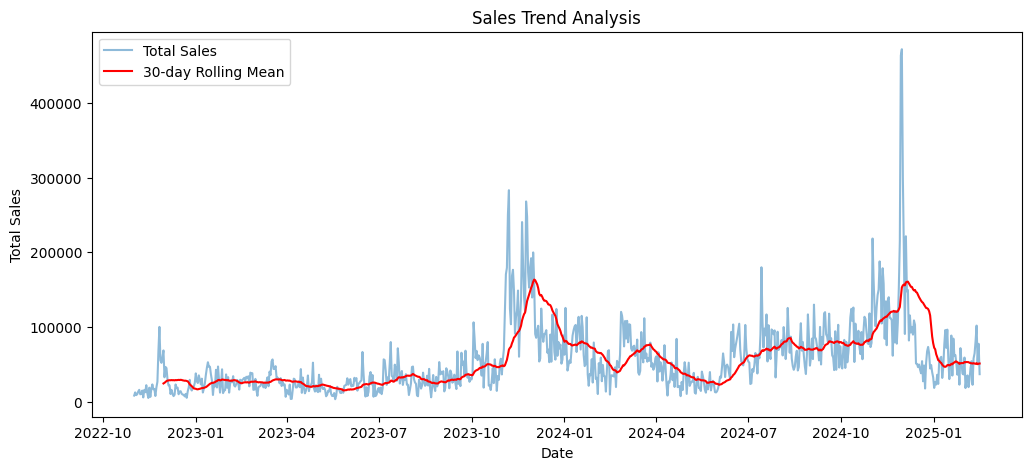

In [8]:
df_daily['Rolling_Mean'] = df_daily['Total'].rolling(window=30).mean()

plt.figure(figsize=(12, 5))
plt.plot(df_daily['Total'], label="Total Sales", alpha=0.5)
plt.plot(df_daily['Rolling_Mean'], label="30-day Rolling Mean", color='red')
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Sales Trend Analysis")
plt.legend()
plt.show()


### Detecting Seasonality

<Axes: title={'center': 'Seasonal Component'}, xlabel='Created at'>

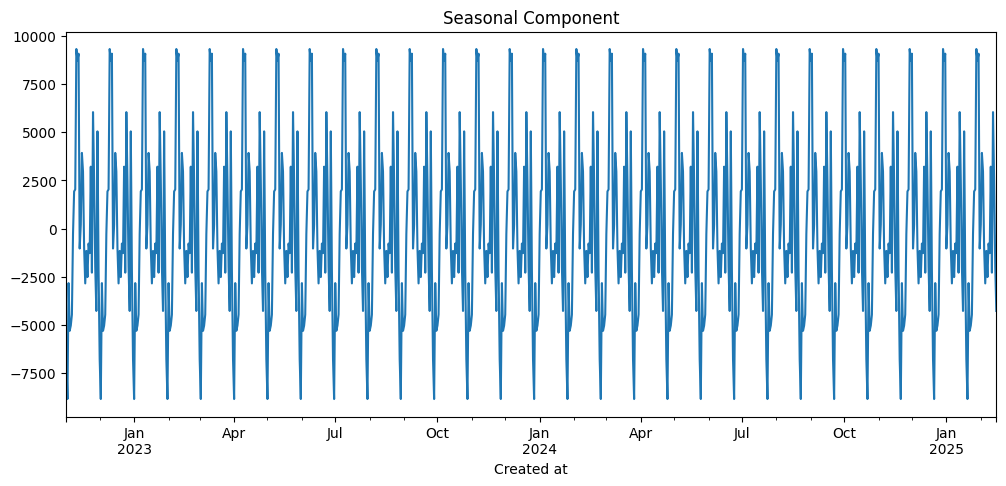

In [9]:
decomposition = seasonal_decompose(df_daily['Total'], model='additive', period=30)
decomposition.seasonal.plot(title="Seasonal Component", figsize=(12, 5))


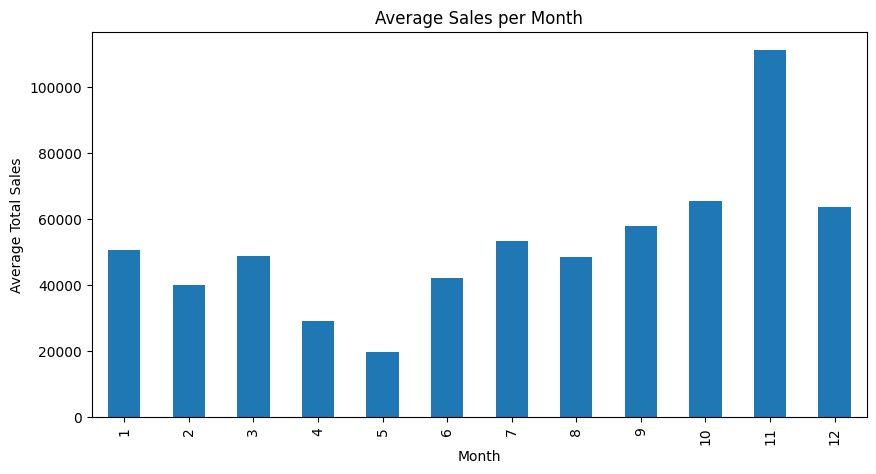

In [10]:
df_daily['month'] = df_daily.index.month
df_monthly = df_daily.groupby('month')['Total'].mean()

df_monthly.plot(kind='bar', figsize=(10, 5), title="Average Sales per Month")
plt.xlabel("Month")
plt.ylabel("Average Total Sales")
plt.show()


### Detecting Cyclic Patterns

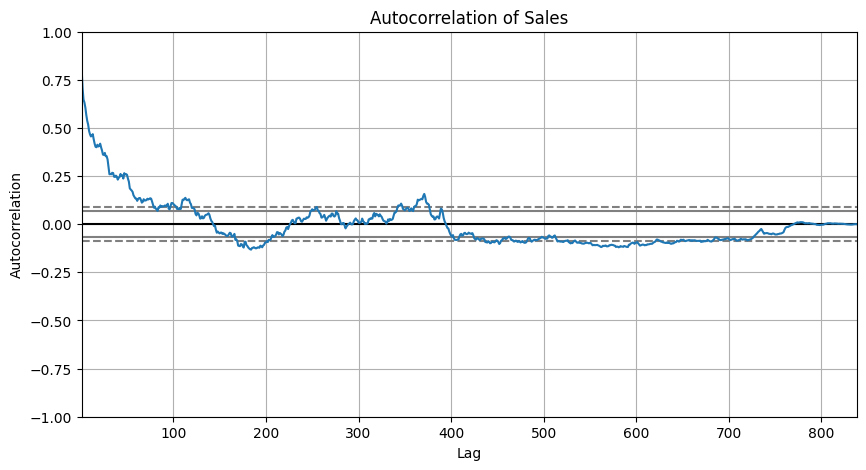

In [11]:
plt.figure(figsize=(10, 5))
autocorrelation_plot(df_daily['Total'])
plt.title("Autocorrelation of Sales")
plt.show()


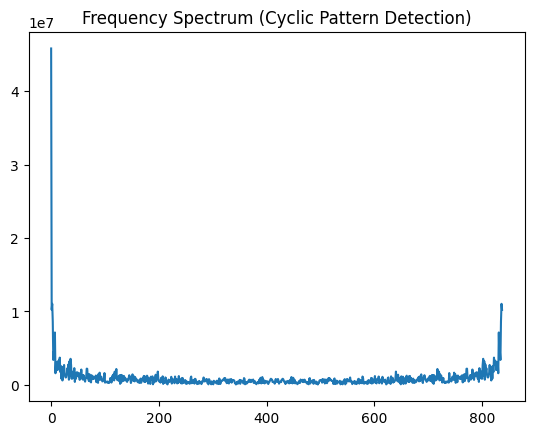

In [12]:
freq_spectrum = np.fft.fft(df_daily['Total'].dropna())
plt.plot(np.abs(freq_spectrum))
plt.title("Frequency Spectrum (Cyclic Pattern Detection)")
plt.show()


### Checking for Stationarity

In [13]:
result = adfuller(df_daily['Total'].dropna())

print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] < 0.05:
    print("The series is stationary (no trend).")
else:
    print("The series is non-stationary (trend present).")


ADF Statistic: -5.055429659427172
p-value: 1.7219752968092498e-05
The series is stationary (no trend).


### Extras

In [14]:
df['is_holiday'] = df['is_holiday'].astype(int)
df['is_weekend'] = df['is_weekend'].astype(int)
df['season'] = df['season'].astype('category').cat.codes
df['day_of_week'] = df['day_of_week'].astype('category').cat.codes

numeric_cols = ['Total', 'Discount Amount', 'Refunded Amount', 'is_holiday',
                'is_weekend', 'item_count', 'season', 'day_of_week']

df_corr = df[numeric_cols]


In [15]:
corr_matrix = df_corr.corr(method='pearson')
print(corr_matrix)


                    Total  Discount Amount  Refunded Amount  is_holiday  \
Total            1.000000         0.352583         0.092005   -0.003420   
Discount Amount  0.352583         1.000000         0.012199   -0.014938   
Refunded Amount  0.092005         0.012199         1.000000   -0.005270   
is_holiday      -0.003420        -0.014938        -0.005270    1.000000   
is_weekend       0.003257        -0.009373         0.002669   -0.038722   
item_count       0.565015         0.466848         0.042086   -0.006133   
season           0.004750         0.005446        -0.013910    0.045653   
day_of_week     -0.004458         0.007364        -0.008624    0.007370   

                 is_weekend  item_count    season  day_of_week  
Total              0.003257    0.565015  0.004750    -0.004458  
Discount Amount   -0.009373    0.466848  0.005446     0.007364  
Refunded Amount    0.002669    0.042086 -0.013910    -0.008624  
is_holiday        -0.038722   -0.006133  0.045653     0.007370  

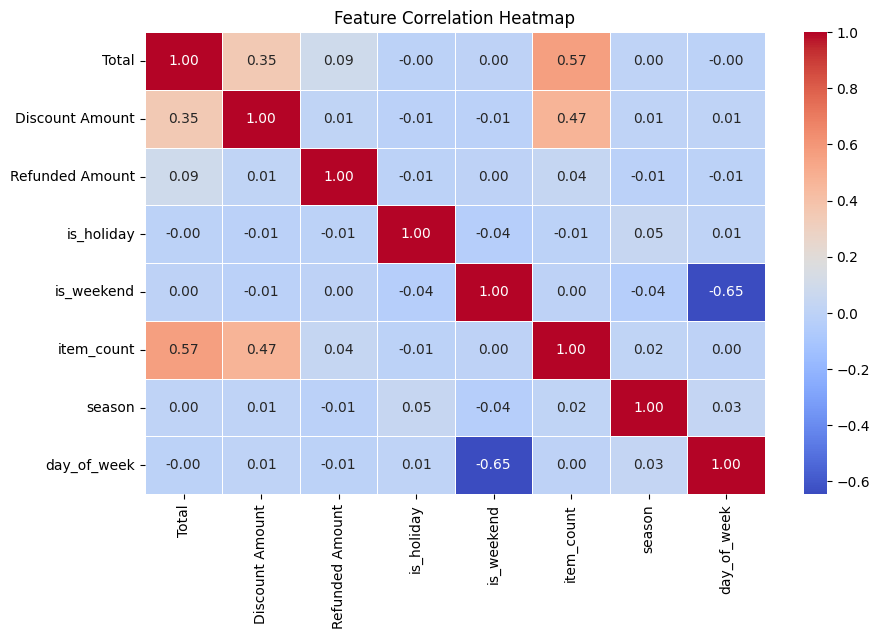

In [16]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


<ipython-input-17-0f3e38434c9e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['season'], y=df['Total'], palette="coolwarm")


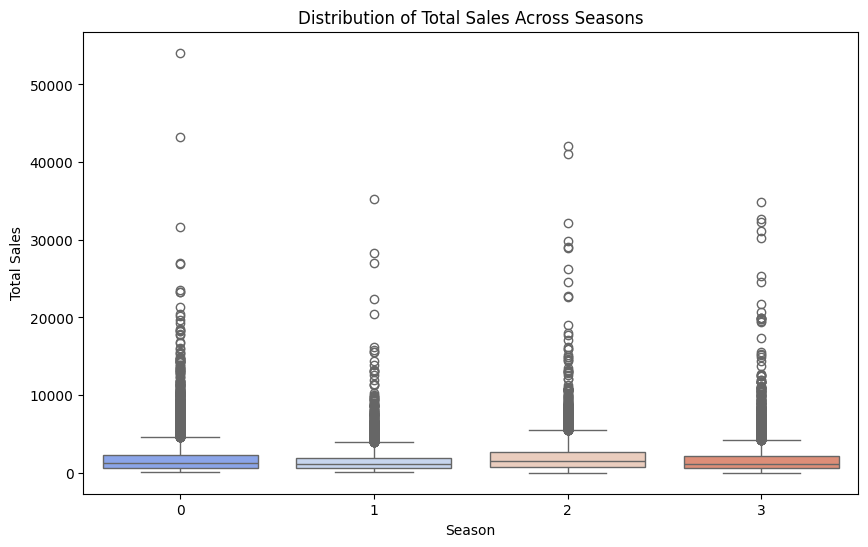

In [17]:
df['season'] = df['season'].astype('category')
plt.figure(figsize=(10,6))
sns.boxplot(x=df['season'], y=df['Total'], palette="coolwarm")
plt.title("Distribution of Total Sales Across Seasons")
plt.xlabel("Season")
plt.ylabel("Total Sales")
plt.show()


In [18]:
season_groups = [group['Total'].values for _, group in df.groupby('season')]

f_stat, p_value = stats.f_oneway(*season_groups)

print(f"ANOVA F-statistic: {f_stat}")
print(f"P-value: {p_value}")
if p_value < 0.05:
    print("There is a significant difference in Total Sales across seasons.")
else:
    print("No significant difference in Total Sales across seasons.")


ANOVA F-statistic: 44.63700597465532
P-value: 9.269483581999416e-29
There is a significant difference in Total Sales across seasons.


<ipython-input-18-1d437b3b13b0>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  season_groups = [group['Total'].values for _, group in df.groupby('season')]


In [19]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey_results = pairwise_tukeyhsd(df['Total'], df['season'])

print(tukey_results)


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
     0      1 -203.9438    0.0  -311.675  -96.2126   True
     0      2  304.2537    0.0  207.9398  400.5676   True
     0      3  -85.1636 0.0599 -172.6915    2.3642  False
     1      2  508.1975    0.0  384.1081  632.2869   True
     1      3  118.7802 0.0461    1.3794  236.1809   True
     2      3 -389.4174    0.0 -496.4375 -282.3973   True
---------------------------------------------------------


In [20]:
# Retrieve the original category order
category_mapping = dict(enumerate(df['season'].astype('category').cat.categories))
print(category_mapping)  # This shows which number corresponds to each season


{0: 0, 1: 1, 2: 2, 3: 3}


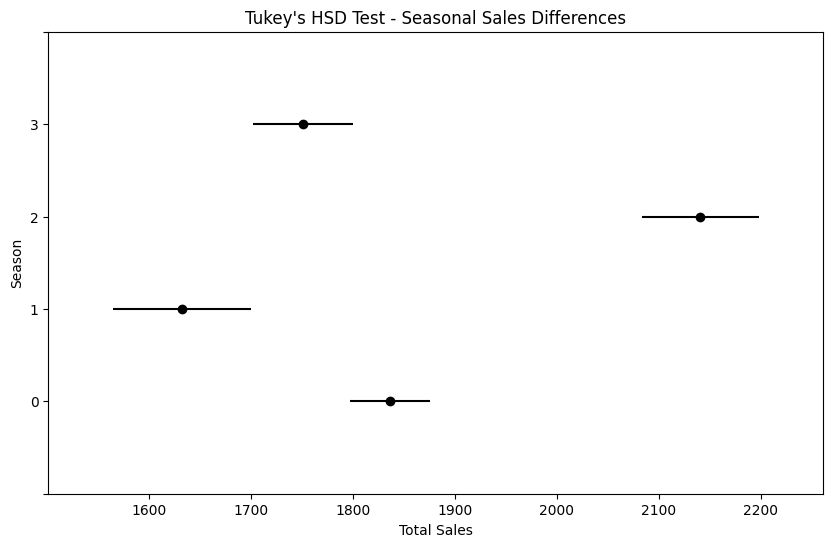

In [21]:
df['season'] = df['season'].map(category_mapping)
tukey_results.plot_simultaneous()
plt.xlabel("Total Sales")
plt.ylabel("Season")
plt.title("Tukey's HSD Test - Seasonal Sales Differences")
plt.show()

<Axes: xlabel='Total', ylabel='Density'>

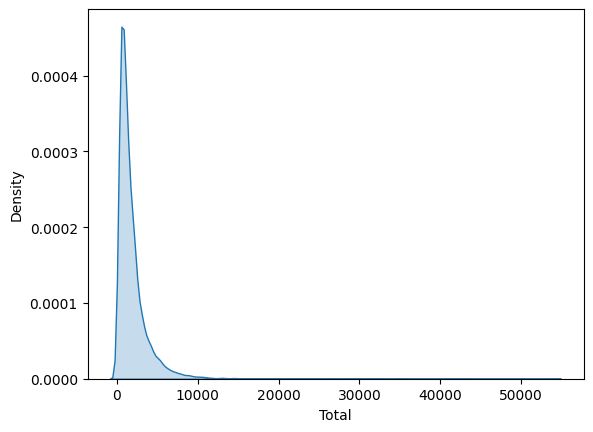

In [22]:
sns.kdeplot(df["Total"], fill=True)


#  Interactive Time Series Plot for dyanmaic Expolration

In [24]:
import plotly.express as px
fig = px.line(df, x="Created at", y="Total", title="Interactive Time Series Analysis")
fig.show()


In [33]:
df['year'] = df['Created at'].dt.year
df['month'] = df['Created at'].dt.month
df['week_of_year'] = df['Created at'].dt.isocalendar().week
df['day_of_week'] = df['Created at'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

print(df.head())


   Unnamed: 0      Name Created at  Subtotal  Shipping   Total  \
0           0  #MC14035 2022-11-01    1150.0       0.0  1150.0   
1           1  #MC14036 2022-11-01     620.0      50.0   670.0   
2           2  #MC14037 2022-11-01     440.0      50.0   490.0   
3           3  #MC14038 2022-11-01     600.0      50.0   650.0   
4           4  #MC14039 2022-11-01     408.0      50.0   458.0   

   Discount Amount Shipping Method Shipping Province Shipping Province Name  \
0             95.0   Free Shipping                 C                  Cairo   
1              0.0   Shipping Rate                 C                  Cairo   
2              0.0   Shipping Rate                GZ                   Giza   
3              0.0   Shipping Rate                 C                  Cairo   
4              0.0   Shipping Rate                 C                  Cairo   

   ... hour day_of_month quarter       ewm_30 Rolling_Std   lag_3 lag_7  \
0  ...    0            1       4  1150.000000        

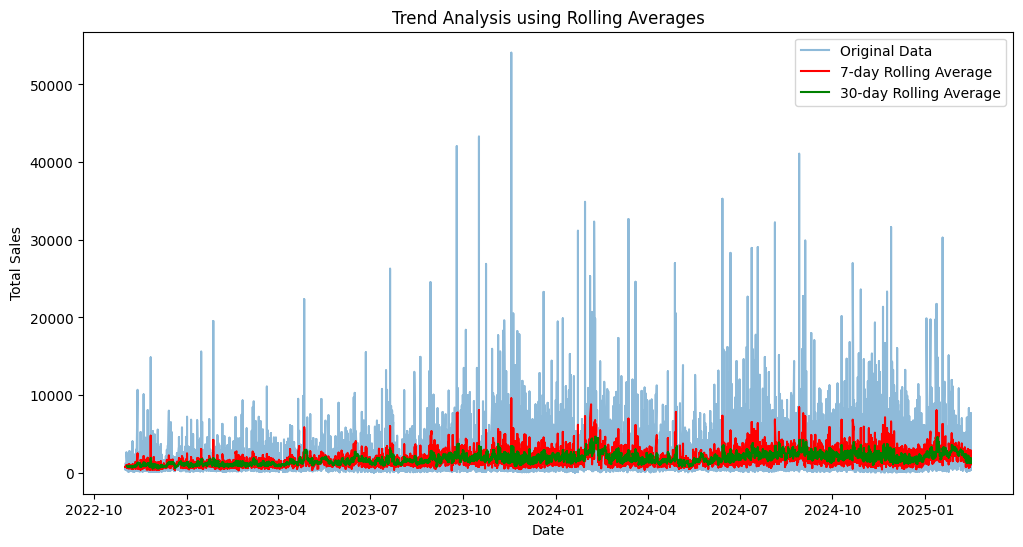

In [38]:
df['rolling_7'] = df['Total'].rolling(window=7).mean()
df['rolling_30'] = df['Total'].rolling(window=30).mean()

plt.figure(figsize=(12,6))
plt.plot(df['Created at'], df['Total'], label="Original Data", alpha=0.5)
plt.plot(df['Created at'], df['rolling_7'], label="7-day Rolling Average", color='red')
plt.plot(df['Created at'], df['rolling_30'], label="30-day Rolling Average", color='green')
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Trend Analysis using Rolling Averages")
plt.legend()
plt.show()


# Clustering Data Using K-Means

<ipython-input-40-d7a2ca156ba8>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



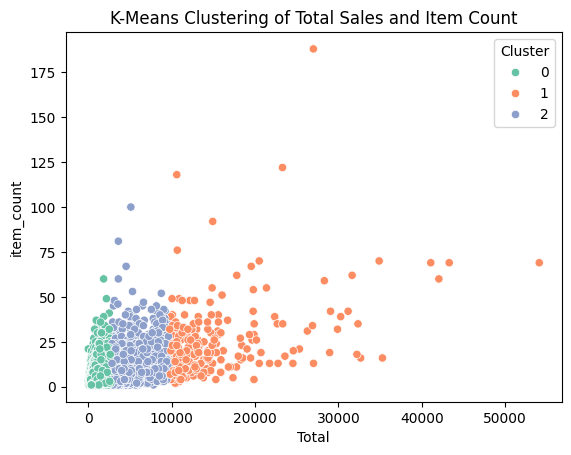

In [40]:
from sklearn.cluster import KMeans


df_cluster = df[['Total', 'item_count']]
kmeans = KMeans(n_clusters=3, random_state=42)
df_cluster['Cluster'] = kmeans.fit_predict(df_cluster)
sns.scatterplot(x=df_cluster['Total'], y=df_cluster['item_count'], hue=df_cluster['Cluster'], palette="Set2")
plt.title("K-Means Clustering of Total Sales and Item Count")
plt.show()
